# Elemental Carbon Content Prediction

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors.kde import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, ElasticNetCV, ElasticNet
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = "C:/Users/danie/Documents/EPFL MA1/Fall 1/Machine Learning/Carbon Analysis Project/data"

In [3]:
df_meas = pd.read_csv(data + "/IMPROVE_2015_measures_cs433.csv")
df_spec = pd.read_csv(data + "/IMPROVE_2015_raw_spectra_cs433.csv")
df_split = pd.read_csv(data + "/IMPROVE_2015_train_test_split_cs433.csv")
df_derive = pd.read_csv(data + "/IMPROVE_2015_2nd-derivative_spectra_cs433.csv")

## Raw Data Train and Test

In [6]:
df_meas = df_meas.set_index("site")
df_EC = pd.DataFrame(df_meas[["ECf:Value","ECf:Unc"]])
df_spec = df_spec.T
"""Align spectra with measurements"""
pd_merged_EC_spec = df_EC.merge(df_spec, right_index=True, left_index=True) #merge EC,EC unc and Spectra

df_split = df_split.set_index("site", drop=True).drop(["Unnamed: 0"], axis=1) #drop last column and set site as index
pd_merged_EC_spec_split = pd_merged_EC_spec.merge(df_split, right_index=True, left_index=True) #merge with split 
del pd_merged_EC_spec #don't need it anymore

KeyError: 'site'

In [7]:
pd_merged_EC_spec_split.head()

,ECf:Value,ECf:Unc,0,1,2,3,4,5,6,7,...,2775,2776,2777,2778,2779,2780,2781,2782,2783,usage
CRLA1_04_21_2015_NM_0_csv,1.844414,1.023308,0.99057,0.99010,0.98964,0.98917,0.98869,0.98822,0.98776,0.98731,...,-0.137830,-0.138150,-0.138390,-0.138530,-0.138560,-0.138480,-0.138240,-0.137840,-0.137270,calibration
TONT1_05_09_2015_NM_0_csv,0.218577,0.203142,0.31219,0.31199,0.31178,0.31157,0.31137,0.31116,0.31096,0.31075,...,-0.063091,-0.062506,-0.061798,-0.060950,-0.059964,-0.058836,-0.057547,-0.056065,-0.054372,calibration
BADL1_11_26_2015_NM_0_csv,0.057109,0.178062,0.58565,0.58535,0.58505,0.58475,0.58446,0.58417,0.58389,0.58361,...,-0.098669,-0.097782,-0.096701,-0.095394,-0.093851,-0.092053,-0.089964,-0.087558,-0.084833,calibration
BRID1_10_27_2015_NM_0_csv,0.090872,0.144012,0.63373,0.63343,0.63314,0.63284,0.63253,0.63223,0.63192,0.63163,...,-0.101440,-0.100430,-0.099210,-0.097748,-0.096049,-0.094104,-0.091885,-0.089359,-0.086516,calibration
SEQU1_04_03_2015_NM_0_csv,1.623977,0.971745,0.51053,0.51023,0.50994,0.50964,0.50935,0.50905,0.50875,0.50846,...,-0.102690,-0.102870,-0.103020,-0.103120,-0.103160,-0.103110,-0.102930,-0.102600,-0.102110,calibration


In [8]:
"""Set training and test data"""
set_train = pd_merged_EC_spec_split[pd_merged_EC_spec_split["usage"] == "calibration"]
set_test = pd_merged_EC_spec_split[pd_merged_EC_spec_split["usage"] == "test"]

In [9]:
"""Uncertainty Variables"""
df_OCU_tr = set_train["ECf:Unc"]
df_OCU_te = set_test["ECf:Unc"]
""" Training and test Variables"""
y_tr = set_train["ECf:Value"]
y_te = set_test["ECf:Value"]
x_tr = set_train.drop(["ECf:Value","ECf:Unc","usage"], axis=1)
x_te = set_test.drop(["ECf:Value","ECf:Unc","usage"], axis=1)


In [10]:
x_tr.head()

,0,1,2,3,4,5,6,7,8,9,...,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783
CRLA1_04_21_2015_NM_0_csv,0.99057,0.99010,0.98964,0.98917,0.98869,0.98822,0.98776,0.98731,0.98685,0.98640,...,-0.137450,-0.137830,-0.138150,-0.138390,-0.138530,-0.138560,-0.138480,-0.138240,-0.137840,-0.137270
TONT1_05_09_2015_NM_0_csv,0.31219,0.31199,0.31178,0.31157,0.31137,0.31116,0.31096,0.31075,0.31055,0.31034,...,-0.063570,-0.063091,-0.062506,-0.061798,-0.060950,-0.059964,-0.058836,-0.057547,-0.056065,-0.054372
BADL1_11_26_2015_NM_0_csv,0.58565,0.58535,0.58505,0.58475,0.58446,0.58417,0.58389,0.58361,0.58332,0.58303,...,-0.099381,-0.098669,-0.097782,-0.096701,-0.095394,-0.093851,-0.092053,-0.089964,-0.087558,-0.084833
BRID1_10_27_2015_NM_0_csv,0.63373,0.63343,0.63314,0.63284,0.63253,0.63223,0.63192,0.63163,0.63133,0.63102,...,-0.102270,-0.101440,-0.100430,-0.099210,-0.097748,-0.096049,-0.094104,-0.091885,-0.089359,-0.086516
SEQU1_04_03_2015_NM_0_csv,0.51053,0.51023,0.50994,0.50964,0.50935,0.50905,0.50875,0.50846,0.50816,0.50786,...,-0.102490,-0.102690,-0.102870,-0.103020,-0.103120,-0.103160,-0.103110,-0.102930,-0.102600,-0.102110


## 2nd Derivative Train and Test 

In [11]:
df_derive = df_derive.T
pd_merged_der_EC_spec = df_EC.merge(df_derive, right_index=True, left_index=True)
pd_merged_der_EC_spec_split = pd_merged_der_EC_spec.merge(df_split, right_index=True, left_index=True)
set_train_der = pd_merged_der_EC_spec_split[pd_merged_der_EC_spec_split["usage"] == "calibration"]
set_test_der = pd_merged_der_EC_spec_split[pd_merged_der_EC_spec_split["usage"] == "test"]
del pd_merged_der_EC_spec

In [12]:
y_tr_der = set_train_der["ECf:Value"]
y_te_der = set_test_der["ECf:Value"]
x_tr_der = set_train_der.drop(["ECf:Value","ECf:Unc","usage"], axis=1)
x_te_der = set_test_der.drop(["ECf:Value","ECf:Unc","usage"], axis=1)

In [13]:
x_tr_der.head()

,0,1,2,3,4,5,6,7,8,9,...,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783
CRLA1_04_21_2015_NM_0_csv,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,...,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076
TONT1_05_09_2015_NM_0_csv,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
BADL1_11_26_2015_NM_0_csv,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,...,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160
BRID1_10_27_2015_NM_0_csv,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,...,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170
SEQU1_04_03_2015_NM_0_csv,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047


In [14]:
wave_no = df_spec.T['wavenumber'] # get wavenumbers

## Field Blank Extraction

In [15]:
""" Returns indexes of spectra that contain a specific label"""
def index_flag(x,label):
    x = x.values
    
    Comp =[]
    
    for Sample_ID in x:
        splits = Sample_ID.split('_')
        if len(splits)>4:
            flag = splits[4]
        else:
            flag = 'NM'
        Comp.append(flag==label)
    return Comp

In [16]:
idx_FB = index_flag(df_spec.index,'FB')
FBs = df_spec[idx_FB]
idx_FB_der = index_flag(df_derive.index,'FB')
FBs_der = df_derive[idx_FB_der]

## Raw Data FBs 

The number of Field Blanks is 463


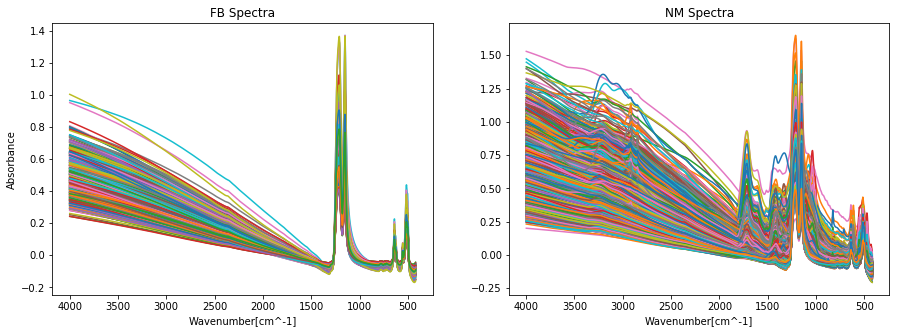

In [23]:
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(1,2,1)
ax1.plot(wave_no,FBs.T)
ax1.invert_xaxis()
ax1.set_xlabel('Wavenumber[cm^-1]')
ax1.set_ylabel('Absorbance')
ax1.set_title('FB Spectra')
ax2 = fig1.add_subplot(1,2,2)
ax2.plot(wave_no,x_tr.T)
ax2.set_xlabel('Wavenumber[cm^-1]')
ax2.invert_xaxis()
ax2.set_title('NM Spectra')
print('The number of Field Blanks is',np.shape(FBs_der)[0])

## 2nd Derivative FB

The number of Field Blanks is 463


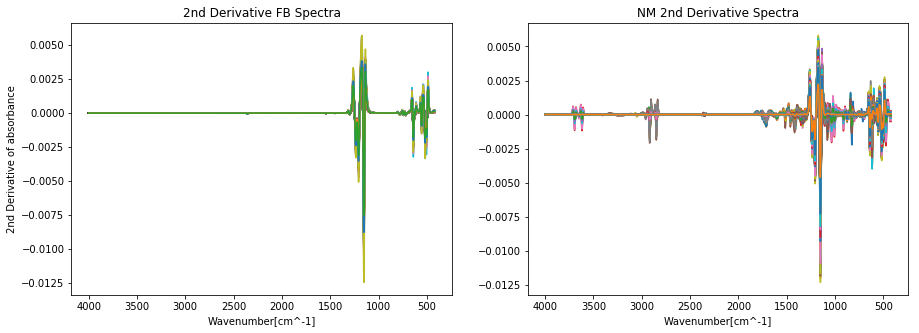

In [128]:
fig2 = plt.figure(figsize=(15,5))
ax1 = fig2.add_subplot(1,2,1)
ax1.plot(wave_no,FBs_der.T)
ax1.invert_xaxis()
ax1.set_xlabel('Wavenumber[cm^-1]')
ax1.set_ylabel('2nd Derivative of absorbance')
ax1.set_title('2nd Derivative FB Spectra')
ax2 = fig2.add_subplot(1,2,2)
ax2.plot(wave_no,x_tr_der.T)
ax2.set_xlabel('Wavenumber[cm^-1]')
ax2.invert_xaxis()
ax2.set_title('NM 2nd Derivative Spectra')
print('The number of Field Blanks is',np.shape(FBs_der)[0])

We can see that there are some regions that are completely flat. We can try to remove these features to save computational power

# Remove zero-features from derivative data

In [15]:

mean_der_spec=np.mean(abs(x_tr_der)) #compute the mean of the abs value of all samples
imp_feat = np.argwhere((mean_der_spec)>1e-6) #only take features whose average is higher than 5e-6
imp_feat #these are the non-zero features

array([[  64],
       [  65],
       [  66],
       ...,
       [2781],
       [2782],
       [2783]], dtype=int64)

In [16]:
x_tr_der_filtered = x_tr_der.iloc[:,imp_feat.flatten()] 
x_te_der_filtered = x_te_der.iloc[:,imp_feat.flatten()]
x_tr_der_compare = np.zeros((2784,))
x_tr_der_compare[imp_feat.flatten()] = mean_der_spec[imp_feat.flatten()]

The number of important features is 2126


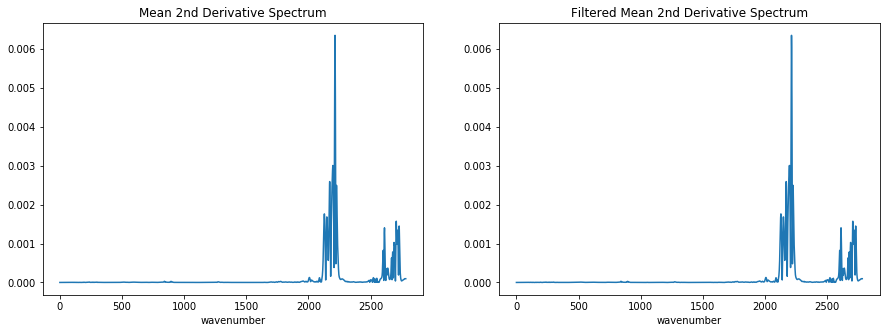

In [17]:
fig = plt.figure(figsize=(15,5))  # create a figure object
ax1 = fig.add_subplot(1, 2, 1)  # create an axes object in the figure
ax1.plot(np.arange(2784),mean_der_spec)
ax1.set_xlabel('wavenumber')
ax1.set_title('Mean 2nd Derivative Spectrum')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.arange(2784),x_tr_der_compare)
ax2.set_xlabel('wavenumber')
ax2.set_title('Filtered Mean 2nd Derivative Spectrum')

print('The number of important features is',np.shape(x_tr_der_filtered)[1])


In [27]:
"""Compared filtered Data using linear regression as a first step"""
lr = LinearRegression()
lr.fit(x_tr_der_filtered,y_tr)
y_pred_der_filtered = lr.predict(x_tr_der_filtered)

lr2 = LinearRegression()
lr2.fit(x_tr_der,y_tr)
y_pred_der = lr2.predict(x_tr_der)



The r2 score of the full spectra is  0.953638491681663
The r2 score of the filtered spectra is  0.9482343566828815


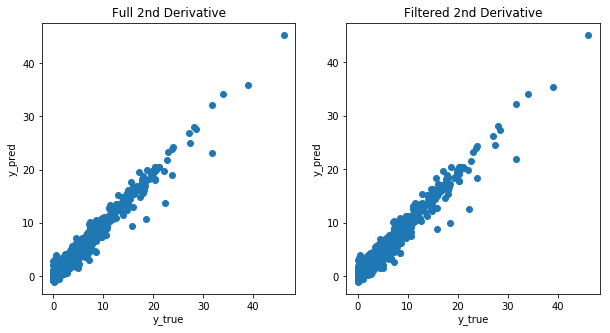

In [28]:
fig2 = plt.figure(figsize=(10,5))
ax1 = fig2.add_subplot(1,2,1)
ax1.scatter(y_tr,y_pred_der)
ax1.set_title('Full 2nd Derivative')
ax1.set_xlabel('y_true')
ax1.set_ylabel('y_pred')
ax2 = fig2.add_subplot(1,2,2)
ax2.scatter(y_tr,y_pred_der_filtered,s=1)
ax2.set_title('Filtered 2nd Derivative')
ax2.set_xlabel('y_true')
ax2.set_ylabel('y_pred')
print('The r2 score of the full spectra is ',r2_score(y_tr,y_pred_der))
print('The r2 score of the filtered spectra is ',r2_score(y_tr,y_pred_der_filtered))

We see that the linear regression does not change by much, and so we can remove the computational cost of ~700 features. 

# Alternative Smoothing Strategies: PCA
We can also extract the features that have the largest variance in the training set. Before doing so, we can remove the features that have the highest variance in the FB since these represent noise. After doing so we can get the principal components of the set. 

## Remove High variance from FB
In order to obtain the samples with highest variance in the FB we must standardize the data and then extract the largest variance

Text(0, 0.5, 'Variance')

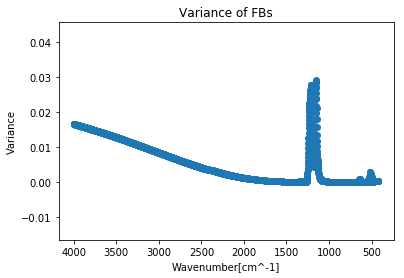

In [17]:
scaler = StandardScaler()
scaler.fit(FBs)
FBs_Std = scaler.transform(FBs)

plt.scatter(wave_no,scaler.var_)
ax = plt.gca()
ax.invert_xaxis()
ax.set_title('Variance of FBs')
ax.set_xlabel('Wavenumber[cm^-1]')
ax.set_ylabel('Variance')



We can remove all the features with variance larger than 0.01


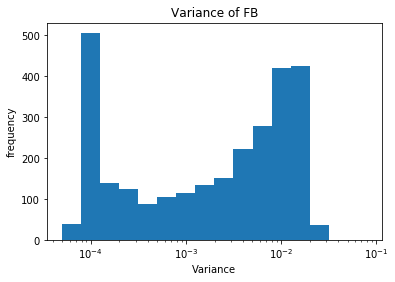

In [18]:
bins = np.power(10.0,(np.arange(-4.3,-1,0.2)))
plt.xscale('log')
plt.hist(scaler.var_,bins=bins)
plt.title('Variance of FB')
plt.xlabel('Variance')
plt.ylabel('frequency')
print('We can remove all the features with variance larger than 0.01')

In [19]:
idx_low_var_FB = np.argwhere(scaler.var_<0.01).flatten()
x_tr_filtered = x_tr.iloc[:,idx_low_var_FB]
x_te_filtered = x_te.iloc[:,idx_low_var_FB]

## Applying PCA to the low variance x_tr
Now that we removed the noise from the FB, we can apply PCA with ~200 components. We will see if 200 features is okay later...

In [20]:
pca = PCA(n_components=200)
pca_tr = pca.fit_transform(x_tr_filtered)
pca_te = pca.transform(x_te_filtered)


Now to remove memory storage, we will convert all datasets to floats of 32 bits

In [161]:
pd.to_numeric(np.series(x_tr),downcast='float')
x_te.apply(to_numeric, downcast='float')
x_tr_der.apply(to_numeric, downcast='float')
x_te_der.apply(to_numeric, downcast='float')
x_tr_der_filtered.apply(to_numeric, downcast='float')
x_te_der_filtered.apply(to_numeric, downcast='float')
pca_tr.apply(to_numeric, downcast='float')
pca_te.apply(to_numeric, downcast='float')

y_tr.apply(to_numeric, downcast='float')
y_te.apply(to_numeric, downcast='float')

TypeError: arg must be a list, tuple, 1-d array, or Series

# Model Comparison 
We will proceed to compare different regression models on the raw data, the filtered 2nd derivative data and the PC data.  We will compare them using 2 metrics: the bias metric (explained below) and the r2. The best model will minimize both of these quantities. 

##  Useful Functions

# Bias metric
This metric will allow us to compare the models based on their bias. It will compute the bias as y=(y_pred-y)/y_uc where y_uc is the signal uncertainty, y is the true y value and y_pred is the prediction from the model. It will also compute the signal to noise ratio (SNR) as y/y_uc. Then, it will smoothen the data by taking a moving average with 10% of the data. 

In [25]:
def compute_bias_metric_noplot(bias, SNR):
    
    # k = percent of data size for smoothing
    k = 0.1
    
    
    # take only samples with SNR > 2
    SNR_ind2 = np.argwhere(SNR > 2).flatten()
    # Bandwidth 
    bandwidth = round(k*len(SNR_ind2))
    # Normalize bias
    bias_n = np.array(bias[SNR_ind2]).flatten()
    # Stack to sort
    
    data = np.stack((np.array(SNR[SNR_ind2]).flatten(),bias_n),axis=0)
    data_sorted = data[:,data.argsort()[0]] #sort with respect to SNR
    y=[]
    for i in range(int(1/k)):
            y.append(np.mean(data_sorted[1,i*bandwidth:(i+1)*bandwidth]))
           
    # Smoother = Moving average, bandwidth of 10% of Data
    return np.max(np.abs(y))

## Cross Validation
This function will perform random cross validation. At each fold it will evaluate the bias metric, the MSE and the r2 with respect to the test sample, which is chosen randomly. The function build-k indices generates an array of k rows containing equal number of indices on each row. Each fold will take a row of this matrix as the test set. Additionally, the function plots the y_pred,y_true on the left, and will give the bias plot as well. 

In [24]:
def build_k_indices(y, k_fold, seed):
    """Permutates data randomly and organizes indices in k rows"""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]

    return np.array(k_indices)

In [26]:
def cross_validation_random(x_tr,y_tr,y_uc,regression_method,plot_title,k_fold=4,seed=1):
    """Splits training data into train and test. 
    cv_type = str representing how the test and train samples will be split
    Random Cross Validation split into k -folds. 
    Function outputs validation bias plot and regression plot
    Function outputs avg mse, r2, bias metric, and sample size
    """
    reg=eval(regression_method)
    indices=build_k_indices(y_tr,k_fold,seed)
        
    avg_mse = 0
    avg_r2 = 0
    avg_bias = 0
    
    y_pred_shuffled = []
    y_true_shuffled = []
    uc_shuffled = []
    
    for k in range(k_fold):
            #training sub data
            x_te_sub = x_tr.iloc[indices[k],:]
            y_te_sub = y_tr[indices[k]]
            y_te_sub_uc = y_uc[indices[k]]
            

            #drop training indices, select test subdata
            #indices_ = np.delete(indices, (k), axis=0).flatten() #Take the complement of the data as test
            indices_ = np.delete(indices, (k), axis=0).flatten()[:int(len(y_tr)/2)] #take half of the train data
            x_tr_sub = x_tr.iloc[indices_,:]
            y_tr_sub = y_tr[indices_]
            

            reg.fit(x_tr_sub,y_tr_sub)
            y_te_sub_pred = reg.predict(x_te_sub)
            
            
            #Bias Calculation
            SNR_sub = y_te_sub/y_te_sub_uc
            bias_te_sub = (y_te_sub_pred - y_te_sub) / y_te_sub_uc
            bias_metric = compute_bias_metric_noplot(bias_te_sub,SNR_sub)
            
            #Compute loss and r2
            avg_mse = avg_mse+mean_squared_error(y_te_sub,y_te_sub_pred)
            avg_r2 = avg_r2+ r2_score(y_te_sub, y_te_sub_pred)
            avg_bias = avg_bias + bias_metric
            
            #Plot 
            plt.scatter(y_te_sub,y_te_sub_pred)
            y_pred_shuffled.append(y_te_sub_pred)
            y_true_shuffled.append(y_te_sub)
            uc_shuffled.append(y_te_sub_uc)
            
            print('Fold # %i Test mean squared error: %.2f' % (k+1,mean_squared_error(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test R2: %.2f' % (k+1,r2_score(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test bias metric: %.2f' % (k+1,bias_metric))
    print('Training Sample Size: ',int(len(y_tr)*(k_fold-1)/k_fold))
    print('Average MSE: ',avg_mse/k_fold)
    print('Average R2: ',avg_r2/k_fold)
    print('Average Bias: ',avg_bias/k_fold)
    plt.suptitle(plot_title, fontsize=20)
    u = np.linspace(0,50)
    plt.plot(u,u, c='black')
    plt.xlabel('y_true', fontsize=18)
    plt.ylabel('y_pred_cv', fontsize=16)
    plt.show()
    
   
    bias_plot(pd.Series(np.array(y_true_shuffled).flatten()),np.array(y_pred_shuffled).flatten(),np.array(uc_shuffled).flatten())
    return  avg_mse/k_fold,avg_r2/k_fold,avg_bias/k_fold,int(len(y_tr)*(k_fold-1)/k_fold)

In [32]:
import seaborn as sns

def bias_plot(y_right, y_pred, OCU):
    """Produces a nice visualization of the bias"""
    bias = (y_pred - y_right) / OCU
    SNR = y_right / OCU
    SNR.name = 'SNR'
    bias.name = 'bias'
    pd_plot = pd.concat([SNR, bias], axis=1)


    sns.jointplot("SNR", "bias", data=pd_plot, kind='reg', scatter_kws={"s": 2},
                  joint_kws={'line_kws':{'color':'black'}});

## Linear Regression Raw Data
We will start with the simplest model on the raw data

Fold # 1 Test mean squared error: 0.69
Fold # 1 Test R2: 0.85
Fold # 1 Test bias metric: 1.00
Fold # 2 Test mean squared error: 0.75
Fold # 2 Test R2: 0.79
Fold # 2 Test bias metric: 0.65
Fold # 3 Test mean squared error: 0.82
Fold # 3 Test R2: 0.82
Fold # 3 Test bias metric: 0.51
Fold # 4 Test mean squared error: 0.96
Fold # 4 Test R2: 0.82
Fold # 4 Test bias metric: 0.56
Training Sample Size:  10021
Average MSE:  0.8054862307731486
Average R2:  0.822460251841983
Average Bias:  0.6830741076385641


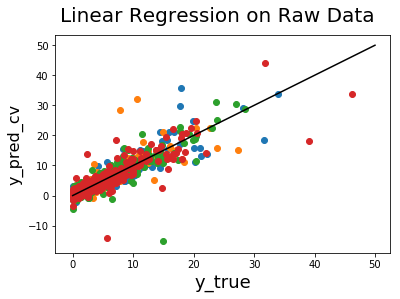

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


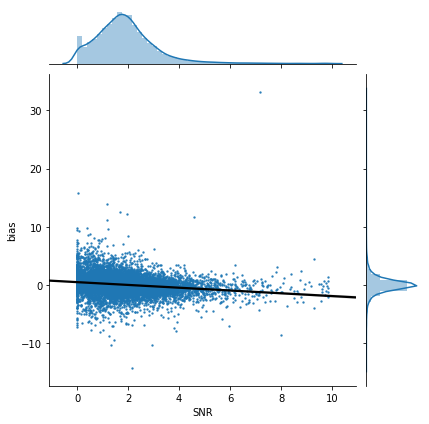

In [29]:
MSE_lin,R2_lin,Biasm_lin,train_size = cross_validation_random(x_tr,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Raw Data',4) #Raw model

## Linear Regression on Derivative Data

Fold # 1 Test mean squared error: 1.13
Fold # 1 Test R2: 0.76
Fold # 1 Test bias metric: 1.53
Fold # 2 Test mean squared error: 0.56
Fold # 2 Test R2: 0.84
Fold # 2 Test bias metric: 1.37
Fold # 3 Test mean squared error: 0.62
Fold # 3 Test R2: 0.87
Fold # 3 Test bias metric: 1.37
Fold # 4 Test mean squared error: 0.74
Fold # 4 Test R2: 0.87
Fold # 4 Test bias metric: 1.40
Training Sample Size:  10021
Average MSE:  0.7616759565671787
Average R2:  0.8335082918579679
Average Bias:  1.4143938978371484


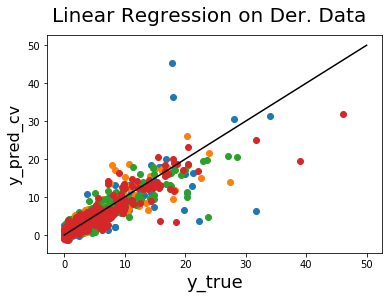

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


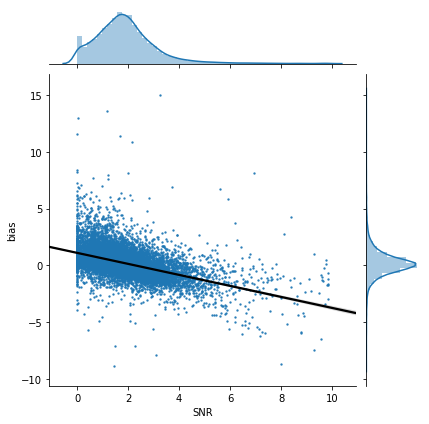

In [30]:
MSE_lin_der,R2_lin_der,Biasm_lin_der,train_size = cross_validation_random(x_tr_der,y_tr,df_OCU_tr,'Ridge(alpha=1e-6)','Linear Regression on Der. Data',4) #Raw model

## Linear Regression Filtered Derivative Data

Fold # 1 Test mean squared error: 0.88
Fold # 1 Test R2: 0.81
Fold # 1 Test bias metric: 1.37
Fold # 2 Test mean squared error: 0.80
Fold # 2 Test R2: 0.78
Fold # 2 Test bias metric: 0.84
Fold # 3 Test mean squared error: 0.85
Fold # 3 Test R2: 0.82
Fold # 3 Test bias metric: 0.76
Fold # 4 Test mean squared error: 1.44
Fold # 4 Test R2: 0.74
Fold # 4 Test bias metric: 0.52
Training Sample Size:  10021
Average MSE:  0.9918066171331341
Average R2:  0.7856015208078053
Average Bias:  0.8725760766182595


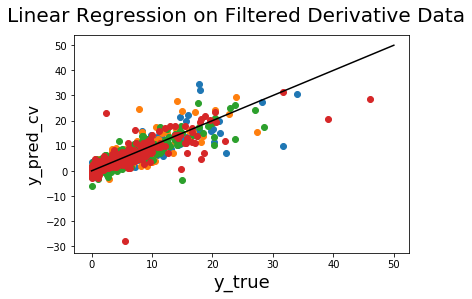

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


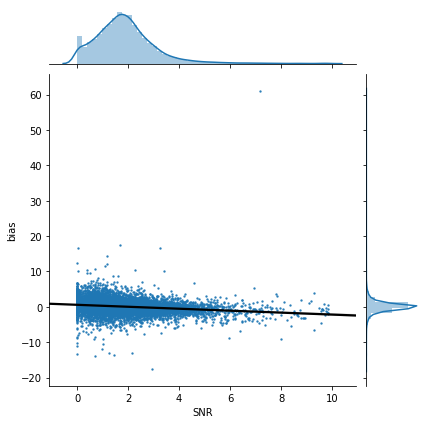

In [31]:
MSE_lin_der_filtered,R2_lin_der_filtered,Biasm_lin_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Filtered Derivative Data',4) #der data

## Linear Regression on PC Set

Fold # 1 Test mean squared error: 0.71
Fold # 1 Test R2: 0.85
Fold # 1 Test bias metric: 1.14
Fold # 2 Test mean squared error: 0.53
Fold # 2 Test R2: 0.85
Fold # 2 Test bias metric: 0.89
Fold # 3 Test mean squared error: 0.46
Fold # 3 Test R2: 0.90
Fold # 3 Test bias metric: 0.60
Fold # 4 Test mean squared error: 0.64
Fold # 4 Test R2: 0.88
Fold # 4 Test bias metric: 0.61
Training Sample Size:  10021
Average MSE:  0.5860624769839902
Average R2:  0.8707051378482018
Average Bias:  0.8117932677169956


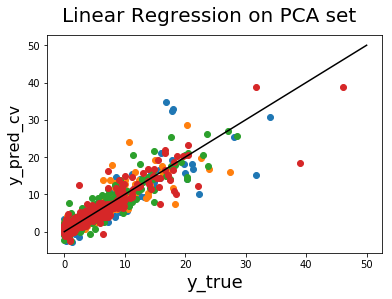

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


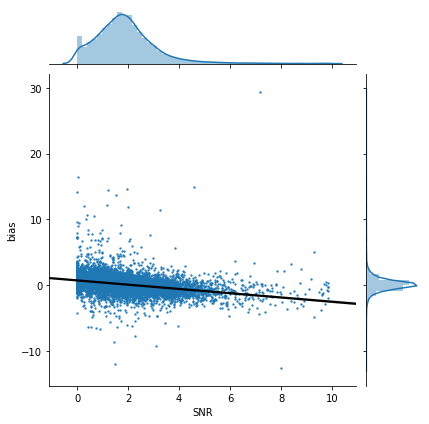

In [33]:
MSE_lin_PCA,R2_lin_PCA,Biasm_lin_PCA,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on PCA set',4) #der data

Comparing the three data sets, it seems that the PCA linear regression gives very good results

## Ridge Regression Raw Data
We will implement ridge regression. We will select the appropriate lambda from the training data

In [34]:
rdge = RidgeCV(alphas=(1e-4,1e-5,1e-6,1e-7))
rdge.fit(x_tr,y_tr)
alpha_raw = rdge.alpha_

In [35]:
print(alpha_raw)

1e-05


Fold # 1 Test mean squared error: 0.62
Fold # 1 Test R2: 0.87
Fold # 1 Test bias metric: 1.07
Fold # 2 Test mean squared error: 0.46
Fold # 2 Test R2: 0.87
Fold # 2 Test bias metric: 0.79
Fold # 3 Test mean squared error: 0.35
Fold # 3 Test R2: 0.93
Fold # 3 Test bias metric: 0.57
Fold # 4 Test mean squared error: 0.60
Fold # 4 Test R2: 0.89
Fold # 4 Test bias metric: 0.78
Training Sample Size:  10021
Average MSE:  0.5067840438285931
Average R2:  0.8885883299863171
Average Bias:  0.8016554312352635


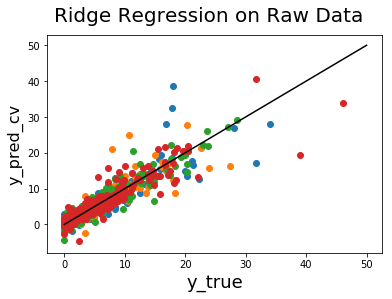

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


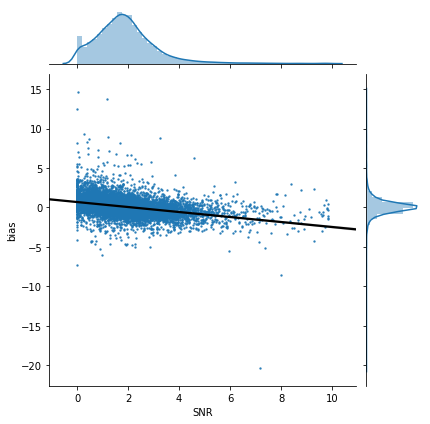

In [36]:
MSE_ridge,R2_ridge,Biasm_ridge,train_size = cross_validation_random(x_tr,y_tr,df_OCU_tr,'Ridge(alpha=1e-5)','Ridge Regression on Raw Data',4) #Raw model

## Ridge Regression 2nd Derivative

In [37]:
rdge.fit(x_tr_der,y_tr)
print(rdge.alpha_)

1e-07


Fold # 1 Test mean squared error: 1.18
Fold # 1 Test R2: 0.75
Fold # 1 Test bias metric: 1.48
Fold # 2 Test mean squared error: 0.53
Fold # 2 Test R2: 0.85
Fold # 2 Test bias metric: 1.15
Fold # 3 Test mean squared error: 0.57
Fold # 3 Test R2: 0.88
Fold # 3 Test bias metric: 1.15
Fold # 4 Test mean squared error: 0.70
Fold # 4 Test R2: 0.87
Fold # 4 Test bias metric: 1.22
Training Sample Size:  10021
Average MSE:  0.7445596968489887
Average R2:  0.837570098826568
Average Bias:  1.248368733113777


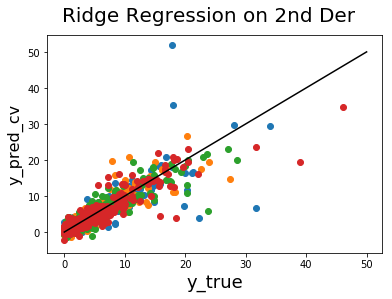

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


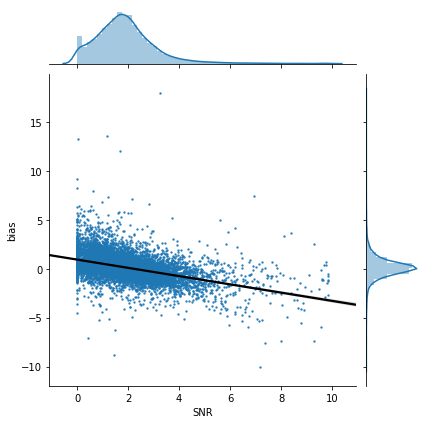

In [38]:
MSE_ridge_der,R2_ridge_der,Biasm_ridge_der,train_size = cross_validation_random(x_tr_der,y_tr,df_OCU_tr,'Ridge(alpha=1e-7)','Ridge Regression on 2nd Der',4) #Raw model

## Ridge Regression Filtered 2nd Derivative

In [39]:
rdge.fit(x_tr_der_filtered,y_tr)
print(rdge.alpha_)

1e-07


Fold # 1 Test mean squared error: 1.18
Fold # 1 Test R2: 0.75
Fold # 1 Test bias metric: 1.48
Fold # 2 Test mean squared error: 0.53
Fold # 2 Test R2: 0.85
Fold # 2 Test bias metric: 1.15
Fold # 3 Test mean squared error: 0.57
Fold # 3 Test R2: 0.88
Fold # 3 Test bias metric: 1.15
Fold # 4 Test mean squared error: 0.71
Fold # 4 Test R2: 0.87
Fold # 4 Test bias metric: 1.22
Training Sample Size:  10021
Average MSE:  0.7465263207032274
Average R2:  0.8371152796849924
Average Bias:  1.2507712713216526


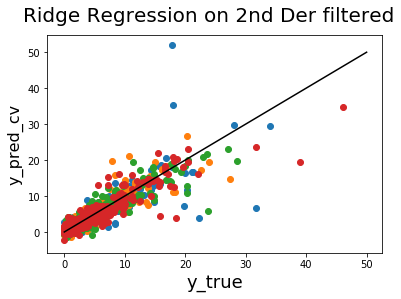

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


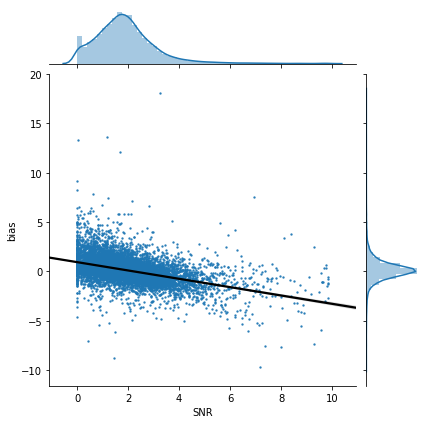

In [40]:
MSE_ridge_der_filtered,R2_ridge_der_filtered,Biasm_ridge_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'Ridge(alpha=1e-7)','Ridge Regression on 2nd Der filtered',4) #Raw model

## Ridge Regression PC Set

In [41]:
rdge.fit(pca_tr,y_tr)
print(rdge.alpha_)

1e-05


Fold # 1 Test mean squared error: 0.71
Fold # 1 Test R2: 0.85
Fold # 1 Test bias metric: 1.17
Fold # 2 Test mean squared error: 0.54
Fold # 2 Test R2: 0.85
Fold # 2 Test bias metric: 0.91
Fold # 3 Test mean squared error: 0.45
Fold # 3 Test R2: 0.90
Fold # 3 Test bias metric: 0.63
Fold # 4 Test mean squared error: 0.61
Fold # 4 Test R2: 0.89
Fold # 4 Test bias metric: 0.70
Training Sample Size:  10021
Average MSE:  0.5781889014809405
Average R2:  0.8720138905545072
Average Bias:  0.8527545245181234


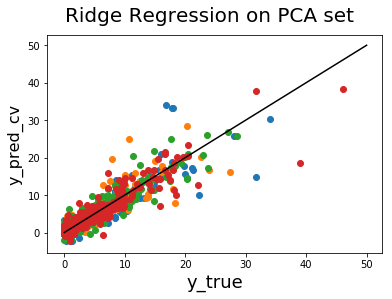

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


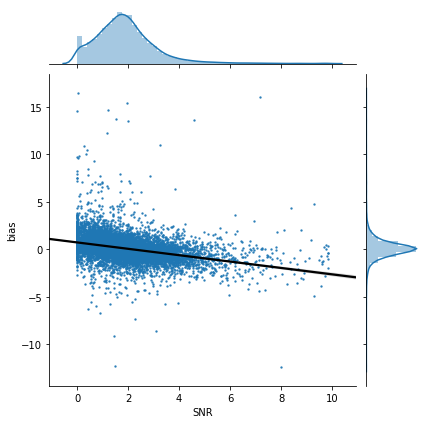

In [42]:
MSE_ridge_pca,R2_ridge_pca,Biasm_ridge_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'Ridge(alpha=1e-5)','Ridge Regression on PCA set',4) #Raw model

# Elastic Net CV on Filtered Data
Since this model is computationally intensive, we decided to compare only the filtered raw data and derivative

## Filtered Derivative

In [46]:
EN = ElasticNetCV(alphas=[1e-3,1e-4,1e-5,1e-6],l1_ratio=([.3,.9, .95,.98,.985,0.99,1]),cv=4,max_iter=2000)
EN.fit(x_tr_der_filtered,y_tr)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\skle

ElasticNetCV(alphas=[0.001, 0.0001, 1e-05, 1e-06], copy_X=True, cv=4,
       eps=0.001, fit_intercept=True,
       l1_ratio=[0.3, 0.9, 0.95, 0.98, 0.985, 0.99, 1], max_iter=2000,
       n_alphas=100, n_jobs=None, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [47]:
print('optimal alpha: ',EN.alpha_)
print('optimal l1_ratio:',EN.l1_ratio_)

optimal alpha:  1e-06
optimal l1_ratio: 1.0


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold # 1 Test mean squared error: 1.17
Fold # 1 Test R2: 0.75
Fold # 1 Test bias metric: 1.64


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold # 2 Test mean squared error: 0.63
Fold # 2 Test R2: 0.82
Fold # 2 Test bias metric: 1.69


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold # 3 Test mean squared error: 0.79
Fold # 3 Test R2: 0.83
Fold # 3 Test bias metric: 1.62


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Fold # 4 Test mean squared error: 0.89
Fold # 4 Test R2: 0.84
Fold # 4 Test bias metric: 1.69
Training Sample Size:  10021
Average MSE:  0.8690296587926434
Average R2:  0.8106305686353068
Average Bias:  1.659632807618885


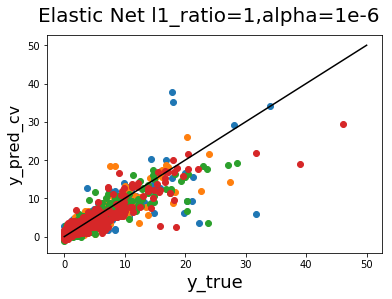

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


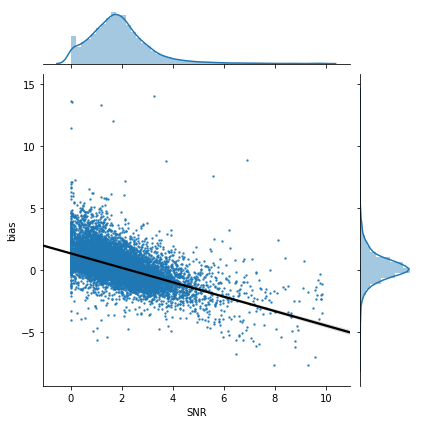

In [48]:
MSE_EN_der_filtered,R2_EN_der_filtered,Biasm_EN_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'ElasticNet(alpha=1e-6,l1_ratio=1,max_iter=3000)','Elastic Net l1_ratio=1,alpha=1e-6',4) #Raw model

Lasso regression seems to be the winner. 

##  ELastic Net on PC Set

In [49]:
EN = ElasticNetCV(alphas=[1e-3,1e-4,1e-5,1e-6],l1_ratio=([.3,.9, .95,.98,.985,0.99,0.995,1]),cv=4,max_iter=2000)
EN.fit(pd.DataFrame(pca_tr),y_tr)

ElasticNetCV(alphas=[0.001, 0.0001, 1e-05, 1e-06], copy_X=True, cv=4,
       eps=0.001, fit_intercept=True,
       l1_ratio=[0.3, 0.9, 0.95, 0.98, 0.985, 0.99, 0.995, 1],
       max_iter=2000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [50]:
print('optimal alpha: ',EN.alpha_)
print('optimal l1_ratio:',EN.l1_ratio_)

optimal alpha:  1e-06
optimal l1_ratio: 1.0


Fold # 1 Test mean squared error: 0.71
Fold # 1 Test R2: 0.85
Fold # 1 Test bias metric: 1.18
Fold # 2 Test mean squared error: 0.51
Fold # 2 Test R2: 0.86
Fold # 2 Test bias metric: 0.94
Fold # 3 Test mean squared error: 0.43
Fold # 3 Test R2: 0.91
Fold # 3 Test bias metric: 0.68
Fold # 4 Test mean squared error: 0.61
Fold # 4 Test R2: 0.89
Fold # 4 Test bias metric: 0.84
Training Sample Size:  10021
Average MSE:  0.5685400838597704
Average R2:  0.8745866825293934
Average Bias:  0.9086145654878524


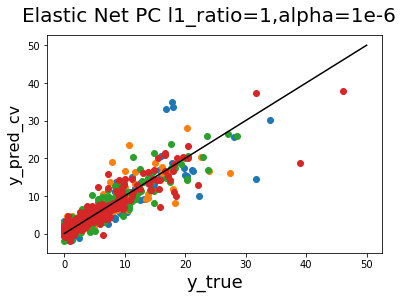

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


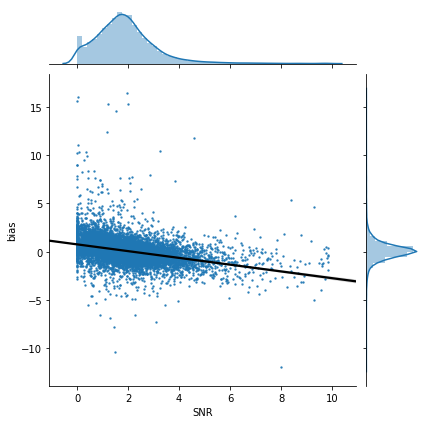

In [51]:
MSE_EN_pca,R2_EN_pca,Biasm_EN_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'ElasticNet(alpha=1e-6,l1_ratio=1,max_iter=3000)','Elastic Net PC l1_ratio=1,alpha=1e-6',4) #Raw model

# Neural Net on Filtered Derivative and PC Data

## Filtered Derivative

## PC Set 

Fold # 1 Test mean squared error: 0.46
Fold # 1 Test R2: 0.90
Fold # 1 Test bias metric: 0.94


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fold # 2 Test mean squared error: 0.36
Fold # 2 Test R2: 0.90
Fold # 2 Test bias metric: 0.71
Fold # 3 Test mean squared error: 0.39
Fold # 3 Test R2: 0.92
Fold # 3 Test bias metric: 0.42
Fold # 4 Test mean squared error: 0.47
Fold # 4 Test R2: 0.91
Fold # 4 Test bias metric: 0.76
Training Sample Size:  10021
Average MSE:  0.4237903471572865
Average R2:  0.9069337282941174
Average Bias:  0.7059165623887202


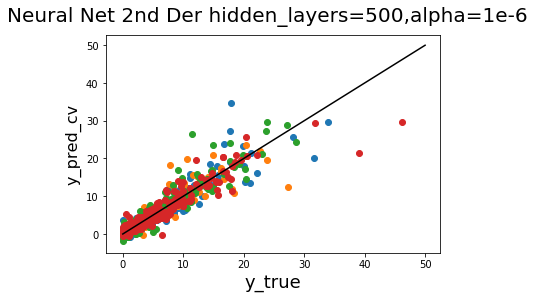

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


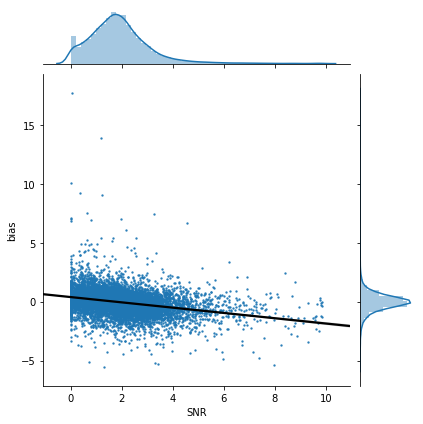

In [52]:
MSE_NN_pca_200,R2_NN_pca_200,Biasm_NN_pca_200,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'MLPRegressor(hidden_layer_sizes=(200,),alpha=1e-6,batch_size=200,max_iter=400)','Neural Net 2nd Der hidden_layers=500,alpha=1e-6',4) #Raw model

## NN Finding the optimal number of hidden layers and alpha for PC Set
We are intersted in finding the best size of the hidden layer and the best alpha. 

In [28]:
def cross_validation_no_plot(x_tr,y_tr,y_uc,regression_method,k_fold=4,seed=1):
    """Splits training data into train and test. 
    cv_type = str representing how the test and train samples will be split
    Random Cross Validation split into k -folds. 
    Function outputs avg mse, r2, bias metric
    """
    reg=eval(regression_method)
    indices=build_k_indices(y_tr,k_fold,seed)
        
    avg_mse = 0
    avg_r2 = 0
    avg_bias = 0
    
    y_pred_shuffled = []
    y_true_shuffled = []
    uc_shuffled = []
    
    for k in range(k_fold):
            #training sub data
            x_te_sub = x_tr.iloc[indices[k],:]
            y_te_sub = y_tr[indices[k]]
            y_te_sub_uc = y_uc[indices[k]]
            

            #drop training indices, select test subdata
            #indices_ = np.delete(indices, (k), axis=0).flatten() #Take the complement of the data as test
            indices_ = np.delete(indices, (k), axis=0).flatten()[:int(len(y_tr)/2)] #take half of the train data
            x_tr_sub = x_tr.iloc[indices_,:]
            y_tr_sub = y_tr[indices_]
            

            reg.fit(x_tr_sub,y_tr_sub)
            y_te_sub_pred = reg.predict(x_te_sub)
            
            
            #Bias Calculation
            SNR_sub = y_te_sub/y_te_sub_uc
            bias_te_sub = (y_te_sub_pred - y_te_sub) / y_te_sub_uc
            bias_metric = compute_bias_metric_noplot(bias_te_sub,SNR_sub)
            
            #Compute loss and r2
            avg_mse = avg_mse+mean_squared_error(y_te_sub,y_te_sub_pred)
            avg_r2 = avg_r2+ r2_score(y_te_sub, y_te_sub_pred)
            avg_bias = avg_bias + bias_metric
            
            #Plot 
            #plt.scatter(y_te_sub,y_te_sub_pred)
            #y_pred_shuffled.append(y_te_sub_pred)
            #y_true_shuffled.append(y_te_sub)
            #uc_shuffled.append(y_te_sub_uc)
            
            print('Fold # %i Test mean squared error: %.2f' % (k+1,mean_squared_error(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test R2: %.2f' % (k+1,r2_score(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test bias metric: %.2f' % (k+1,bias_metric))
    print(regression_method)
    print('Training Sample Size: ',int(len(y_tr)*(k_fold-1)/k_fold)) 
    print('average mse: ', avg_mse/k_fold)
    print('average r2: ',avg_r2/k_fold)
    print('average bias: ',avg_bias/k_fold)
   
    #bias_plot(pd.Series(np.array(y_true_shuffled).flatten()),np.array(y_pred_shuffled).flatten(),np.array(uc_shuffled).flatten())
    return  avg_mse/k_fold, avg_r2/k_fold , avg_bias/k_fold , int(len(y_tr)*(k_fold-1)/k_fold)

In [41]:
"""Variable Initialization"""
alphas = np.logspace(-6,-4,3)
#alphas = 10.0**np.arange(-6,-3)
hidden_layers = np.arange(100,600,100)
mse_nn_pca_arr=pd.DataFrame(data=None, index=alphas, columns=hidden_layers)
r2_nn_pca_arr=pd.DataFrame(data=None, index=alphas, columns=hidden_layers)
biasm_nn_pca_arr=pd.DataFrame(data=None, index=alphas, columns=hidden_layers)


In [78]:
alphas_extra = [1e-7,1e-3]
mse_nn_pca_line=pd.DataFrame(data=None, index=alphas_extra, columns=hidden_layers)
r2_nn_pca_line=pd.DataFrame(data=None, index=alphas_extra, columns=hidden_layers)
biasm_nn_pca_line=pd.DataFrame(data=None, index=alphas_extra, columns=hidden_layers)

In [79]:
mse_nn_pca_arr.head()

,100,200,300,400,500
0.000001,0.419103,0.415178,0.430394,0.425306,0.43389
0.000010,0.416821,0.439908,0.419349,0.43883,0.433074
0.000100,0.414767,0.445705,0.424757,0.412473,0.42244


In [80]:
"""Grid search for size of layer and alpha"""

for alpha_ in (alphas_extra):
    
    for hidden_layer in hidden_layers:
        reg_method = 'MLPRegressor(hidden_layer_sizes=(%d,),alpha=%.7f,batch_size=200,max_iter=400)'%(hidden_layer,alpha_)
        print(reg_method)
       
        mse_nn_pca_line.loc[alpha_,hidden_layer], r2_nn_pca_line.loc[alpha_,hidden_layer],  biasm_nn_pca_line.loc[alpha_,hidden_layer], train_size =  cross_validation_no_plot(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,reg_method)
    

MLPRegressor(hidden_layer_sizes=(100,),alpha=0.0000001,batch_size=200,max_iter=400)
Fold # 1 Test mean squared error: 0.46
Fold # 1 Test R2: 0.90
Fold # 1 Test bias metric: 0.88
Fold # 2 Test mean squared error: 0.38
Fold # 2 Test R2: 0.89
Fold # 2 Test bias metric: 0.74
Fold # 3 Test mean squared error: 0.37
Fold # 3 Test R2: 0.92
Fold # 3 Test bias metric: 0.55
Fold # 4 Test mean squared error: 0.49
Fold # 4 Test R2: 0.91
Fold # 4 Test bias metric: 0.64
MLPRegressor(hidden_layer_sizes=(100,),alpha=0.0000001,batch_size=200,max_iter=400)
Training Sample Size:  10021
average mse:  0.4243573851681098
average r2:  0.9067764332219195
average bias:  0.7030937557276621
MLPRegressor(hidden_layer_sizes=(200,),alpha=0.0000001,batch_size=200,max_iter=400)
Fold # 1 Test mean squared error: 0.47
Fold # 1 Test R2: 0.90
Fold # 1 Test bias metric: 0.94
Fold # 2 Test mean squared error: 0.37
Fold # 2 Test R2: 0.90
Fold # 2 Test bias metric: 0.73
Fold # 3 Test mean squared error: 0.39
Fold # 3 Test R2:

In [59]:
r2_nn_pca_arr.style.background_gradient(cmap='summer')

,100,200,300,400,500
1e-06,0.907719,0.90888,0.905694,0.906873,0.905113
1e-05,0.908972,0.90397,0.907402,0.904267,0.905624
0.0001,0.908735,0.902359,0.906564,0.909638,0.908041


In [81]:
r2_nn_pca_line

,100,200,300,400,500
1.000000e-07,0.906776,0.906209,0.904832,0.909049,0.90432
1.000000e-03,0.906975,0.905947,0.902917,0.899127,0.903453


In [52]:
mse_nn_pca_arr

,100,200,300,400,500
0.000001,0.419103,0.415178,0.430394,0.425306,0.43389
0.000010,0.416821,0.439908,0.419349,0.43883,0.433074
0.000100,0.414767,0.445705,0.424757,0.412473,0.42244


In [61]:
biasm_nn_pca_arr.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3 entries, 1e-06 to 0.0001
Data columns (total 5 columns):
100    3 non-null object
200    3 non-null object
300    3 non-null object
400    3 non-null object
500    3 non-null object
dtypes: object(5)
memory usage: 224.0+ bytes


In [95]:
#merge data
biases = [biasm_nn_pca_arr,biasm_nn_pca_line]
mses = [mse_nn_pca_arr,mse_nn_pca_line]
r2s = [r2_nn_pca_arr,r2_nn_pca_line]

biasm_nn_pca_merged = pd.concat(biases).sort_index(axis=0)
mse_nn_pca_merged = pd.concat(mses).sort_index(axis=0)
r2_nn_pca_merged = pd.concat(r2s).sort_index(axis=0)



In [99]:
# trick: Use pickle to avoid recalculating
import pickle

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)


In [101]:
save_pickle((biasm_nn_pca_merged,mse_nn_pca_merged,r2_nn_pca_merged),'./heatmap_EC')

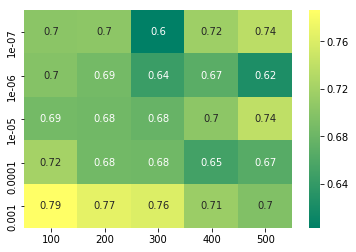

In [96]:
sns.heatmap(biasm_nn_pca_merged.astype('float'),annot=True,cmap='summer')

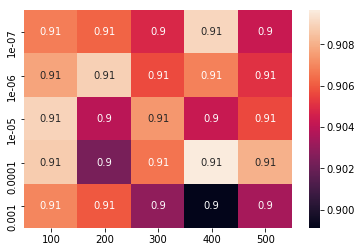

In [97]:
sns.heatmap(r2_nn_pca_merged.astype('float'),annot=True)

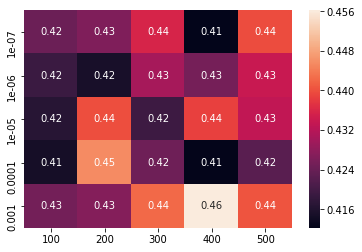

In [98]:
sns.heatmap(mse_nn_pca_merged.astype('float'),annot=True)

# Comparison Summary

In [186]:
 model_info = {'Dataset/Model': ['linear','der_linear','der_linear_filtered','linear_pca(200 comps)','Ridge','Ridge_der',\
          'Ridge_der_filtered','Ridge_pca','EN_der_filtered','EN_pca','NN_pca']\
         , 'MSE': [MSE_lin,MSE_lin_der,MSE_lin_der_filtered,MSE_lin_PCA,MSE_ridge,MSE_ridge_der,\
                  MSE_ridge_der_filtered,MSE_ridge_pca,MSE_EN_der_filtered,MSE_EN_pca,MSE_NN_pca]\
        ,'R2': [R2_lin,R2_lin_der,R2_lin_der_filtered,R2_lin_PCA,R2_ridge,R2_ridge_der,R2_ridge_der_filtered,\
                R2_ridge_pca,R2_EN_der_filtered,R2_EN_pca,R2_NN_pca]\
            ,'Bias Metric': [Biasm_lin,Biasm_lin_der,Biasm_lin_der_filtered,Biasm_lin_PCA,Biasm_ridge,Biasm_ridge_der,Biasm_ridge_der_filtered,\
                             Biasm_ridge_pca,Biasm_EN_der_filtered,Biasm_EN_pca,Biasm_NN_pca]}
pd_model_info = pd.DataFrame(model_info).set_index('Dataset/Model')

In [187]:
pd_model_info

,Bias Metric,MSE,R2
Dataset/Model,,,
linear,0.321824,7.447211,0.973716
der_linear,0.642369,6.073772,0.978515
der_linear_filtered,0.323040,6.566569,0.976608
linear_pca(200 comps),0.465625,5.552583,0.980347
Ridge,0.454819,5.177631,0.981787
Ridge_der,0.513906,5.310279,0.981359
Ridge_der_filtered,0.516304,5.315318,0.981342
Ridge_pca,0.501774,5.309197,0.981384
EN_der_filtered,0.704342,6.310196,0.977430


In [189]:
pd_model_info.to_csv('Comparison_models_OC')

Text(0,0.5,'Bias Metric')

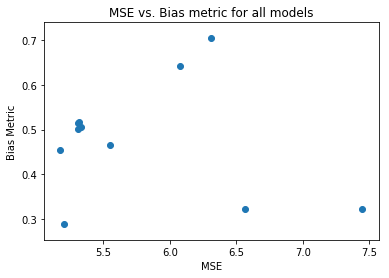

In [192]:
plt.scatter(pd_model_info.iloc['MSE'],pd_model_info['Bias Metric'])
plt.title('MSE vs. Bias metric for all models')
plt.xlabel('MSE')
plt.ylabel('Bias Metric')


In [208]:
pd_model_info.iloc[np.argsort(pd_model_info['MSE']**2+(1+pd_model_info['Bias Metric'])**2),:]


,Bias Metric,MSE,R2
Dataset/Model,,,
NN_pca,0.289226,5.201127,0.981852
Ridge,0.454819,5.177631,0.981787
Ridge_pca,0.501774,5.309197,0.981384
Ridge_der,0.513906,5.310279,0.981359
Ridge_der_filtered,0.516304,5.315318,0.981342
EN_pca,0.505180,5.330997,0.981309
linear_pca(200 comps),0.465625,5.552583,0.980347
der_linear,0.642369,6.073772,0.978515
EN_der_filtered,0.704342,6.310196,0.977430
